# TME 2: Velib 

Data is structured as follow:
* Every minute data is collected from the 1217 stations in all paris.

* histo: a matrix (1217xminutes) the number of velib disponibles.

* take: a matrix (1217xminutes) the number of velib taken.

* stations: id_velib -> name,address,coord_y,coord_x,banking,bonus,number or places
 * id_velib are sparse, between {903 - 44102}
* idx_stations: id_velib -> matrix index (histo,take)
* stations_idx: matrix index (histo,take) -> id_velib

In [97]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

fname = "velib.npz"
obj = np.load(fname)

histo = obj['histo']
take = obj['take']
stations = dict(obj['stations'].tolist())
idx_stations = dict(obj['idx_stations'].tolist())
stations_idx = dict(obj['stations_idx'].tolist()) 
from pylab import rcParams
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

# Density estimation.

We'll use the parzen window method to estimate the density function of the random variable: the amount of bikes at a given position.

Principle of density estimation is based on 2 hypothesis.
* We model the probability of $k$ among $n$ data points defined on a certain feature domain space to be drawn from a volume of the feature space $R$ as a uniform distribution with no replacement.  $P(X\in R) = \frac{k}{n}$
* By definition of probability of a random variable defined over a continuos domain $P(X\in R) =  \int_{x\in R}p(x)dx$, supposing $p(x)$ being homogeneus over the volume $R$ with its volume being $\int_{x\in R}dx=V$.

$p(x)\int_{x\in R}dx = \frac{k}{n} \implies p(x) = \frac{k}{nV} $

To apply this to our dataset we'll need a function telling us how many data points fall into a certain region.
These function are known as kernels.
* $\phi(x) = 1_{|x|<0.5}$ the door function.
* density $p(x)$ is therefore reformulated over a dataset: $p(x)=\sum\limits_{i=1}^n \frac{\phi(\frac{x-x_i}{h})}{nV}$, with $n$ = #datasetpoints, $h$ = widht of the door function.

It can also be proven that kernel function allways work under 2 conditions.
* $\int\phi(x)dx = 1$
* $\phi(x)\geq 0$

So we can use different kernel fuction for example $\phi(x)=\frac{1}{\sqrt{2\pi}}e^{-x^2\frac{1}{2}}$

Turns out that we can estimate a density function as a mixture of density functions with fixed paramenters.




In [113]:
# load the image to plot data onto
parismap = mpimg.imread('paris-48.806-2.23--48.916-2.48.jpg')
## GPS coordinates
xmin,xmax = 2.23,2.48   ## coord_x min and max
ymin,ymax = 48.806,48.916 ## coord_y min and max

# create the data to contain the coordinates for each station
station_coord = np.zeros((len(idx_stations),2))
for i,idx in idx_stations.items():
    station_coord[i,0] =stations[idx][3]
    station_coord[i,1]= stations[idx][2]

steps = 25
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]

def parzen(x):
    return int(np.abs(x)<0.5)

def gaussian(x):
    return (1/float(np.sqrt(np.pi*2)))*(np.exp((-(x)**2)*0.5))

def parzen_estimation(kernel,h,values_x,x,data_n,n,V):
    px = np.zeros(x)
    for i in range(x):
        for j in range(n):
            norm_dist = np.linalg.norm((values_x[i])-data_n[j])/float(h)
            px[i]+= kernel(norm_dist)#/float(V*n)
    return px/np.sum(px)

kernel = parzen
h = (xmax-xmin)/float(steps)
V = h**2
x = (steps*steps)
values_x = grid

n = station_coord.shape[0]
data_n = station_coord

px = parzen_estimation(kernel,h,values_x,x,data_n,n,V)
parzen_density = px.reshape((steps,steps))

kernel = gaussian
h = (xmax-xmin)/float(steps)
V = h**2
x = (steps*steps)
values_x = grid

n = station_coord.shape[0]
data_n = station_coord

px2 = parzen_estimation(kernel,h,values_x,x,data_n,n,V)
gauss_density = px2.reshape((steps,steps))


# Paris Map

Here's the density estimation using the parzen and the gaussian windowing function.

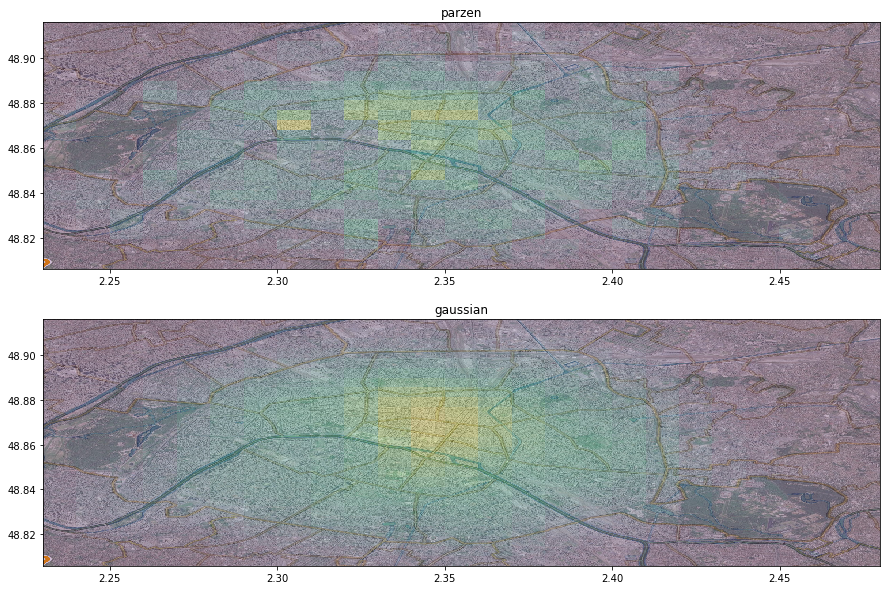

In [115]:
f, axarr = plt.subplots(2,figsize=(15,10))

axarr[0].set_title("parzen")
axarr[0].imshow(parismap,extent=[xmin,xmax,ymin,ymax], interpolation='nearest', aspect='auto')
axarr[0].imshow(parzen_density,extent=[xmin,xmax,ymin,ymax], interpolation='nearest', aspect='auto',\
               alpha=0.25,origin = "lower")

axarr[1].set_title("gaussian")
axarr[1].imshow(parismap,extent=[xmin,xmax,ymin,ymax], interpolation='nearest', aspect='auto')
axarr[1].imshow(gauss_density,extent=[xmin,xmax,ymin,ymax], interpolation='nearest', aspect='auto',\
               alpha=0.25,origin = "lower")

plt.show()

In [16]:
def temporal_histogram(station, data, days_interval=1, delta=60):
    # default min_intervalis a day
    min_interval = days_interval*1440
    days = data.shape[1]/min_interval
    acc_histo = np.zeros(min_interval)
    discretization_step = min_interval/delta
    acc_histo_delta = np.zeros(discretization_step)
    N = np.sum(data[station])
    for day in range(days):
        acc_histo += data[station][day*min_interval:(day+1)*min_interval]
    for i in range(discretization_step):
        acc_histo_delta[i] = np.sum(acc_histo[i*delta:(i+1)*delta])
    return acc_histo_delta/N
        
stations_n,overall_t = take.shape
hourly_time_density = {}
for stat in range(stations_n):
    hourly_time_density[stat] = temporal_histogram(stat,take)

/home/mario/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


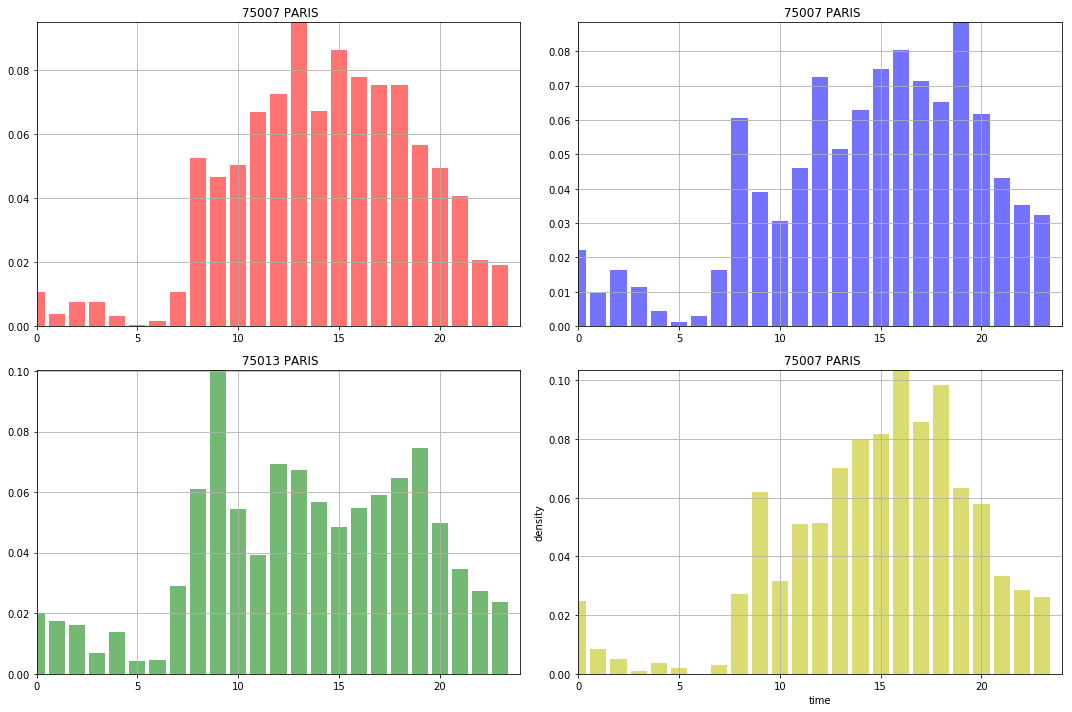

In [17]:
# the histogram of the data
hours_a_day = 24
indices = [1,40,502,1003]
colors = ['r','g','b','y']
f, axarr = plt.subplots(2, len(indices)/2,figsize=(15,10))
for i in range(len(indices)):
    stat_id = idx_stations[i]
    h = np.max(hourly_time_density[i])
    axarr[i%2,i/2].bar(range(hours_a_day), hourly_time_density[i], facecolor=colors[i%len(colors)], alpha=0.55)
    axarr[i%2,i/2].set_title(stations[stat_id][1][-12:])
    axarr[i%2,i/2].grid(True)
    plt.xlabel('time')
    plt.ylabel('density')
    axarr[i%2,i/2].axis([0, 24, 0, h])
    plt.tight_layout() 

plt.xlabel('time')
plt.ylabel('density')
plt.tight_layout() 
plt.show()

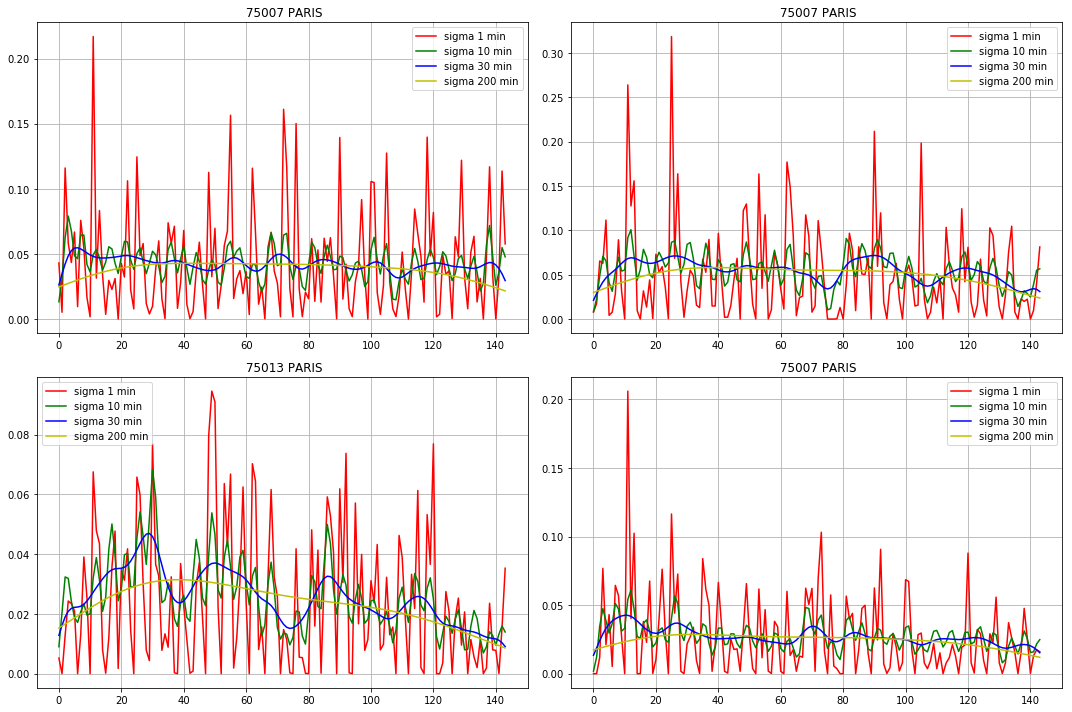

In [33]:
def gaussian_kernel(sigma):
    def f(x,mu):
        exponent = ( (x-mu)**2/float(2*(sigma**2)) )
        coeff_normalizazz = 1/float(np.sqrt(2*(sigma**2)*np.pi))
        return coeff_normalizazz*np.exp(-exponent)
    return f

def gaussian_window(x):
    return np.sqrt(2*np.pi)*np.exp(-0.5*x**2)

def kernel_temporal_histogram(time, kernel, days_interval=1, delta=10):
    # default min_intervalis a day
    min_per_day = 60*24
    # number of minutes per specified days
    min_interval = days_interval*min_per_day
    # number of days in the dataset
    days = time.shape[0]/min_interval
    x_time = np.sum(time[:min_interval*days].reshape(min_interval,days),axis=1)/days
    N = np.sum(x_time)
    x_domain = np.arange(min_interval)    
    dt = min_interval/delta
    p_x_time = np.zeros(dt)
    vkernel = np.vectorize(kernel)
    for dti in range(dt):
        p_x_time[dti] = np.sum(vkernel(x_domain,dti*delta)*x_time)
    return p_x_time

sigmas = [1.,10.,30.,200.]
indices = [1,40,502,1003]
colors = ['r','g','b','y']
f, axarr = plt.subplots(2, len(indices)/2,figsize=(15,10))
for i in range(len(indices)):
    stat_id = idx_stations[i]
    axarr[i%2,i/2].set_title(stations[stat_id][1][-12:])
    plots = []
    for j in range(len(sigmas)):
        pi = kernel_temporal_histogram(take[indices[i]],gaussian_kernel(sigmas[j]))
        plot, = axarr[i/2,i%2].plot(pi,colors[j%len(colors)],label="sigma %.0f min" % sigmas[j])
        axarr[i/2,i%2].grid(True)
        plots += [plot]
    axarr[i/2,i%2].legend(handles=plots)
plt.tight_layout() 
plt.grid(True)
plt.show()

# Answers:

* if steps are to few the estimation is too corse and the graph show no face or curvature (meaning modes, means, and observable parameters). If they're too few each bin will contain only one example, to the extend of the measurement definition (wich is an "histogramming" function itself).

* In this example we estimated the mean value density function, so we took in account all days.

* the role of parameters is to smooth out histograms. For $p(x)$ the larger the window, more datapoints will be considered into the estimation.